In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from py15sacla import hdfselection
import h5py
from ipywidgets import interact, fixed
from scipy.ndimage import gaussian_filter

import glob

%matplotlib nbagg

# Set runs and active motor that define scan

In [2]:
run_range = range(545445, 545595+1)
scanned = 'opt_delay'

h5sel = hdfselection.HDFSelection('/work/mdean/compressed/comp_{}.h5'.format(run_range[1]))
print("Names are :\n" + "\t".join(h5sel.names))

for run in run_range:
    if len(glob.glob('/work/mdean/compressed/comp_{}.h5'.format(run))) != 1:
           print('/work/mdean/compressed/comp_{}.h5 not found!'.format(run))


Names are :
/I0	/accelerator	/huber_chi	/huber_phi	/huber_theta	/huber_twotheta	/image	/laser_selector	/opt_delay	/opt_nd	/run	/sample_theta	/xfel_selector


## Read out different fields of scan

In [3]:
def get_field(run, field):
    h5sel = hdfselection.HDFSelection('/work/mdean/compressed/comp_{}.h5'.format(run))
    try:
        value = h5sel[field][0].value
    except IndexError:
        print("Run {} field {} not found".format(run, field))
        if field == 'image':
            value = np.zeros((1024, 512)) + np.NaN
        else:
            value = np.NaN
    h5sel.hdffile.close()
    return value

x = np.array([np.mean(get_field(run, scanned)) for run in run_range])
Morig = np.array([get_field(run, 'image') for run in run_range])
I0 = np.array([np.mean(get_field(run, 'I0')) for run in run_range])

M = np.copy(Morig)

<IPython.core.display.Javascript object>


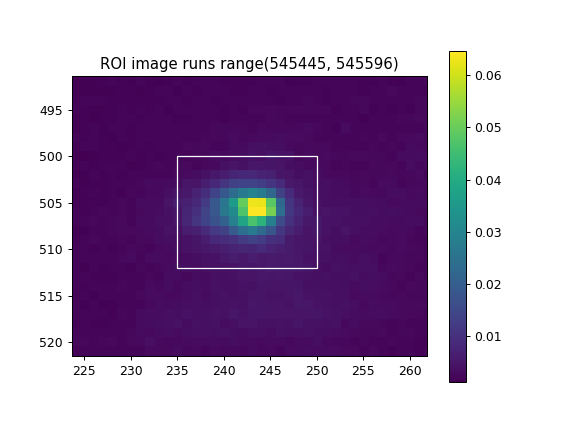

<IPython.core.display.Javascript object>


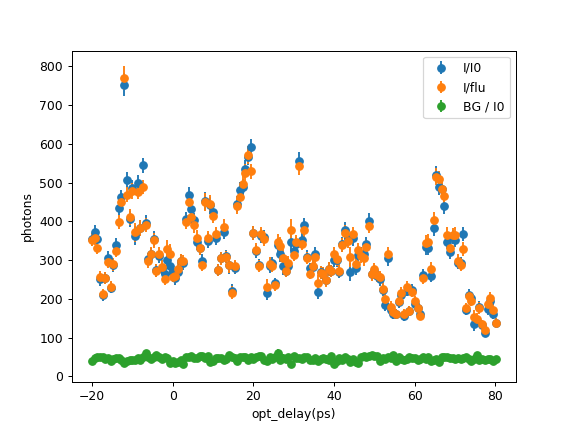

In [5]:
y0, y1, x0, x1 = 500, 512, 235, 250
ROI = np.s_[:,y0:y1,x0:x1]
ROI_BG = np.s_[:,y0+100:y1+100,x0:x1]

M = Morig[ROI]
B = Morig[ROI_BG]

plt.figure()
full_image = np.nanmean(Morig, axis=0)
ROI_image = np.nanmean(M, axis=0)
plt.imshow(full_image, vmin=np.nanpercentile(full_image,5), vmax=np.nanpercentile(ROI_image,99))
rect = patches.Rectangle((x0, y0), (x1-x0), (y1-y0), edgecolor='w', facecolor='none')
plt.gca().add_patch(rect)
plt.title('ROI image runs {}'.format(run_range))
plt.colorbar()

plt.figure()

I = np.sum(M, (1,2)) * len(I0)
BG = np.sum(B, (1,2)) * len(I0)

M_no_ROI = np.copy(Morig)
M_no_ROI[:, ROI[0], ROI[1]] = np.NaN
flu = np.nansum(M_no_ROI, (1,2)) * len(I0) * (M_no_ROI.shape[0] * M_no_ROI.shape[1]) / (M.shape[0] * M.shape[1])

flu_norm = flu / np.nanmean(flu)
I0 /= np.nanmean(I0)

if scanned == 'opt_delay':
    plt.errorbar(x*6.67/1000, I/I0, np.sqrt(I)/I0, fmt='o', label='I/I0')
    plt.errorbar(x*6.67/1000, I/flu_norm, np.sqrt(I)/flu_norm, fmt='o', label='I/flu')
    plt.errorbar(x*6.67/1000, BG/I0, np.sqrt(BG)/I0, fmt='o', label='BG / I0')
    plt.xlabel(scanned + '(ps)')
else:
    plt.errorbar(x, I/I0, np.sqrt(I)/I0, fmt='o', label='I/I0')
    plt.errorbar(x, I/flu_norm, np.sqrt(I)/flu_norm, fmt='o', label='I/flu')
    plt.errorbar(x, BG/I0, np.sqrt(BG)/I0, fmt='o', label='BG / I0')
    plt.xlabel(scanned + '(pulses)')

plt.ylabel('photons')
plt.legend()

## Examine images 1 by 1

<IPython.core.display.Javascript object>


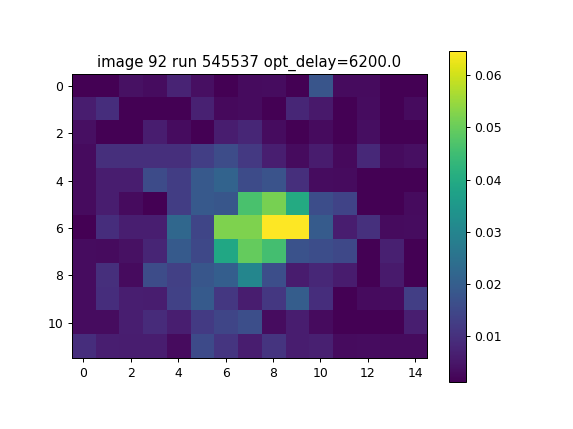

In [6]:
M = np.copy(Morig)
Mav = np.nanmean(M, 0)
MROIav = np.nanmean(Morig[:,y0:y1,x0:x1], axis=0)

def plot_1(M, run_range, x, y0=y0, y1=y1, x0=x0, x1=x1,  n=0,
               vmin=np.nanpercentile(Mav, 5), vmax=np.nanpercentile(MROIav, 95)):
    plt.figure()
    image = M[n,y0:y1, x0:x1]
    plt.imshow(image, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("image {} run {} {}={}".format(n, run_range[n], scanned, x[n]))


interact(plot_1, M=fixed(M), run_range=fixed(run_range), x=fixed(x),
         y0=(0, M.shape[1]), y1=(0, M.shape[1]),
         x0=(0,M.shape[2]), x1=(0,M.shape[2]),
         n=(0, M.shape[0]),
         vmin=(np.nanpercentile(Mav,1), np.nanpercentile(MROIav,99), 0.0001),
         vmax=(np.nanpercentile(Mav,1), np.nanpercentile(MROIav,99), 0.0001))

## Interact with dataset

<IPython.core.display.Javascript object>


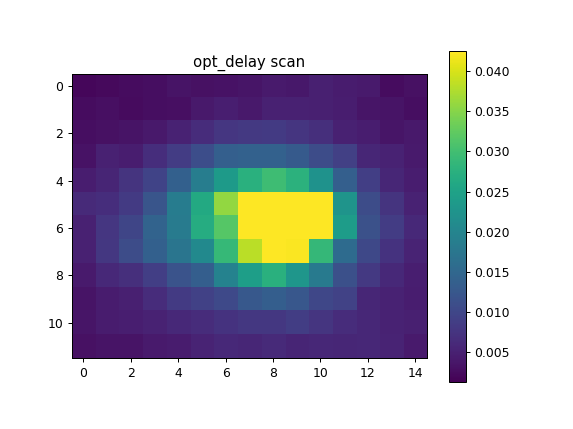

<function __main__.plot_images>

In [8]:
def plot_images(M, run_range, scanned,  x, y0=y0, y1=y1, x0=x0, x1=x1,  startind=0, endind=M.shape[0],
               vmin=np.nanpercentile(Mav, 5), vmax=np.nanpercentile(MROIav, 95)):
    plt.figure()
    image = np.nanmean(M[startind:endind,y0:y1, x0:x1], axis=0)
    plt.imshow(image, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("{} scan".format(scanned))
    
M = np.copy(Morig)
Mav = np.nanmean(M, 0)
MROIav = np.nanmean(Morig[:,y0:y1,x0:x1], axis=0)

interact(plot_images, M=fixed(M), run_range=fixed(run_range), scanned=fixed(scanned), x=fixed(x),
         y0=(0, M.shape[1]), y1=(0, M.shape[1]),
         x0=(0,M.shape[2]), x1=(0,M.shape[2]),
         startind=(0, M.shape[0]), endind=(0, M.shape[0]),
         vmin=(np.nanpercentile(Mav,1), np.nanpercentile(MROIav,99), 0.0001),
         vmax=(np.nanpercentile(Mav,1), np.nanpercentile(MROIav,99), 0.0001))